# Imports

In [33]:
import pandas as pd
from pandas.api.types import is_string_dtype

import numpy as np
from math import sqrt

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split

# Statistics
from pingouin import ancova
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# PCA
from sklearn.decomposition import PCA

# ML
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Loading Data

In [34]:
with open("sample_dataset.csv") as file:
        bestand = pd.read_csv(file,sep=",")

# format the headers
bestand.columns = bestand.iloc[0]
bestand = bestand.drop(bestand.index[0])

# Convert columns to floats
headers_to_float = bestand.columns[2:]
bestand[headers_to_float] = bestand[headers_to_float].astype(float)

# change ref system to categorical var
bestand["SYSTEM"] = pd.factorize(bestand['SYSTEM'])[0]
bestand["SITE"] = pd.factorize(bestand['SITE'])[0]

# Split and Scale Data

In [35]:
# The target variable
target = "Organic Carbon"

# Splitting data for different systems
bestand = bestand[bestand["Clay"] <= 15 ]

# Scale all numeric variables
bestand_numbers = bestand.iloc[:,3:]
bestand_numbers_values = StandardScaler().fit_transform(bestand_numbers.values)
bestand.iloc[:,3:] = bestand_numbers_values
# Drop autocorrelated columns
bestand = bestand.drop("Corg_Clay", axis=1)
#bestand = bestand.drop("Dissolved Org. Carbon", axis=1)

def split_data(bestand):
    # Categories and explanatory vars split
    Categories = bestand.iloc[:,:3]
    Explanatory_Variables = bestand.iloc[:,3:]

    # Move into X,y
    X = Explanatory_Variables.drop(target, axis=1)
    y = Explanatory_Variables[target]

    # Train, test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    return Categories, Explanatory_Variables, X, y, X_train, X_test, y_train, y_test

Categories, Explanatory_Variables, X, y, X_train, X_test, y_train, y_test = split_data(bestand)



# Data Exploration

<AxesSubplot:xlabel='0', ylabel='0'>

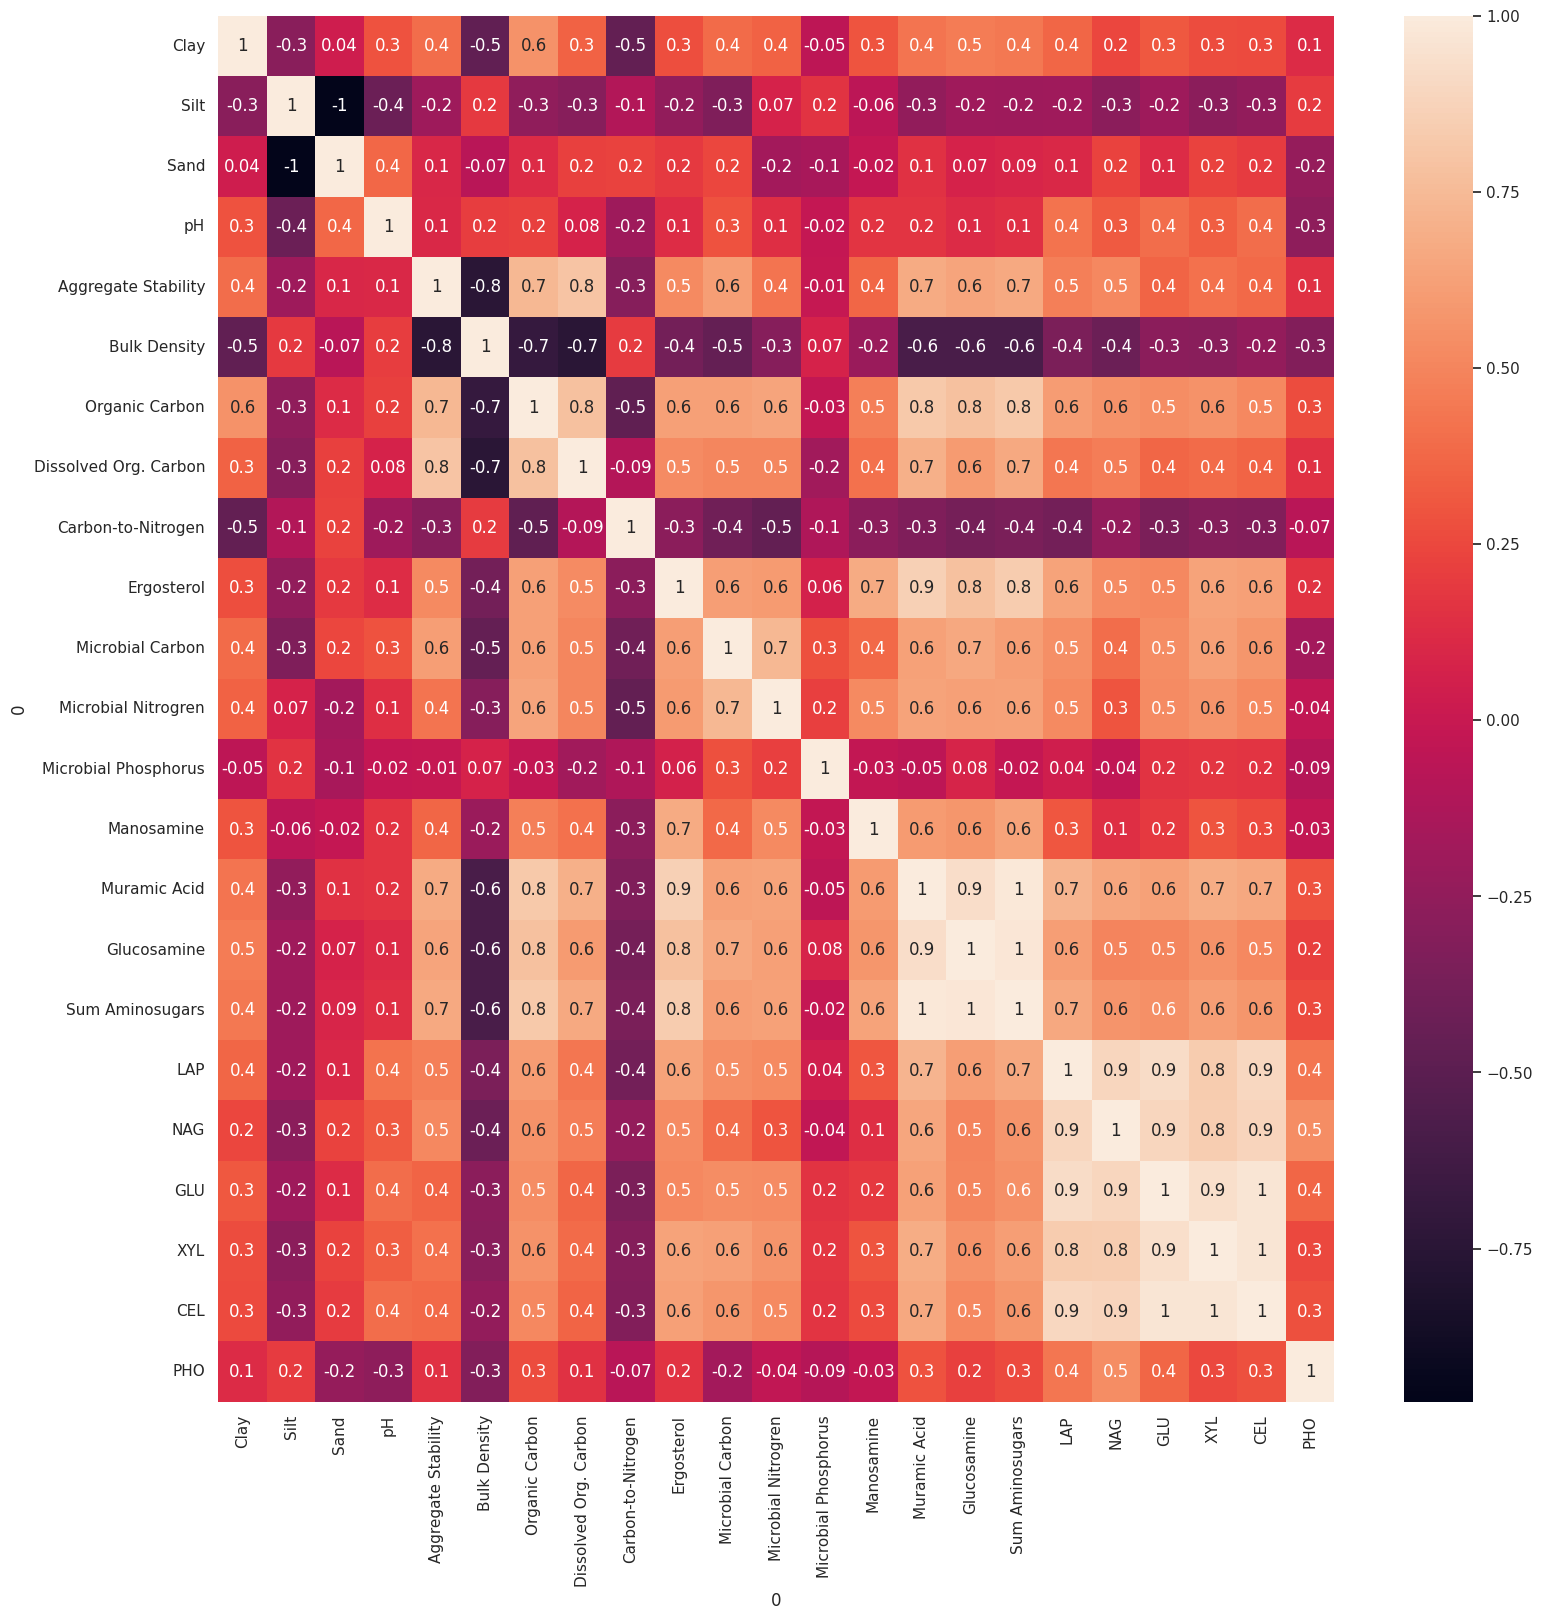

In [36]:
sns.set(rc={'figure.figsize':(18,18)})
correlations = Explanatory_Variables.corr()
sns.heatmap(correlations, annot=True, fmt='.1g')

# Feature Selection

## PCA

Reduce from  (39, 23)  to  (39, 8) variables while retaining 90% variance
Explained variance: 0.9158087060578628


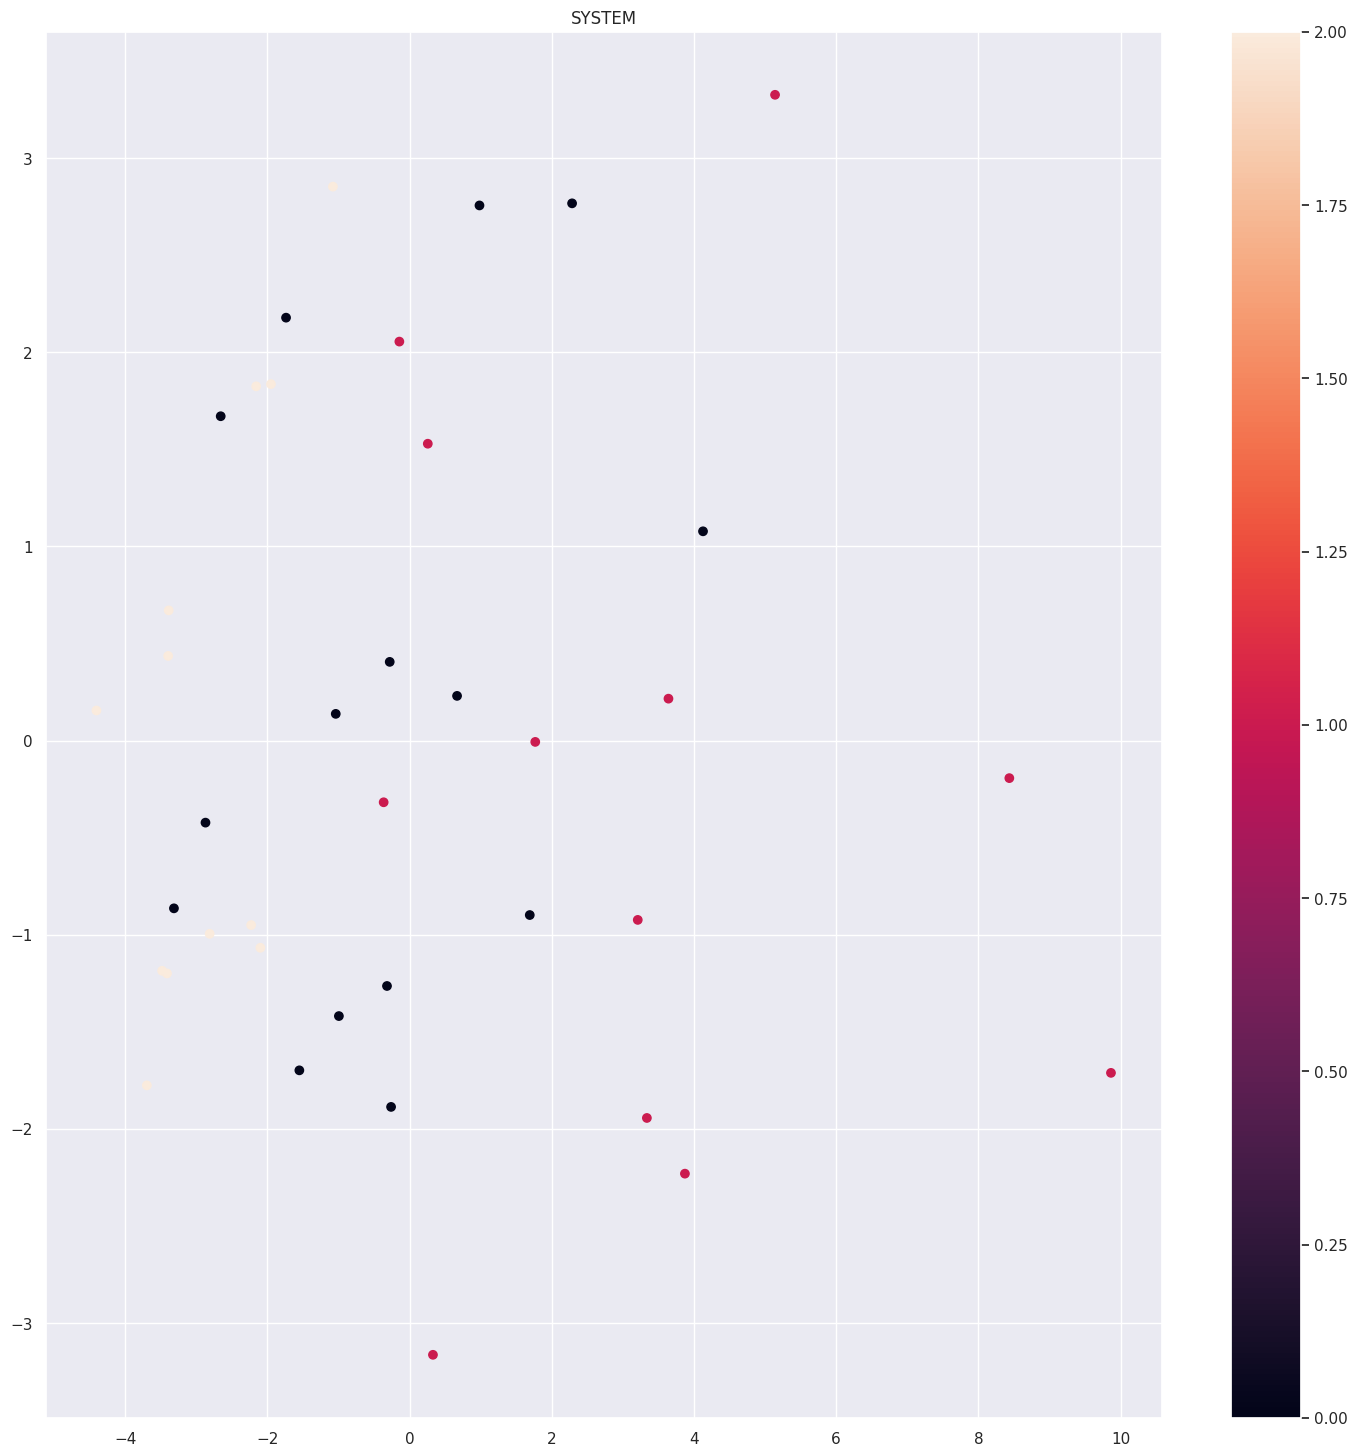

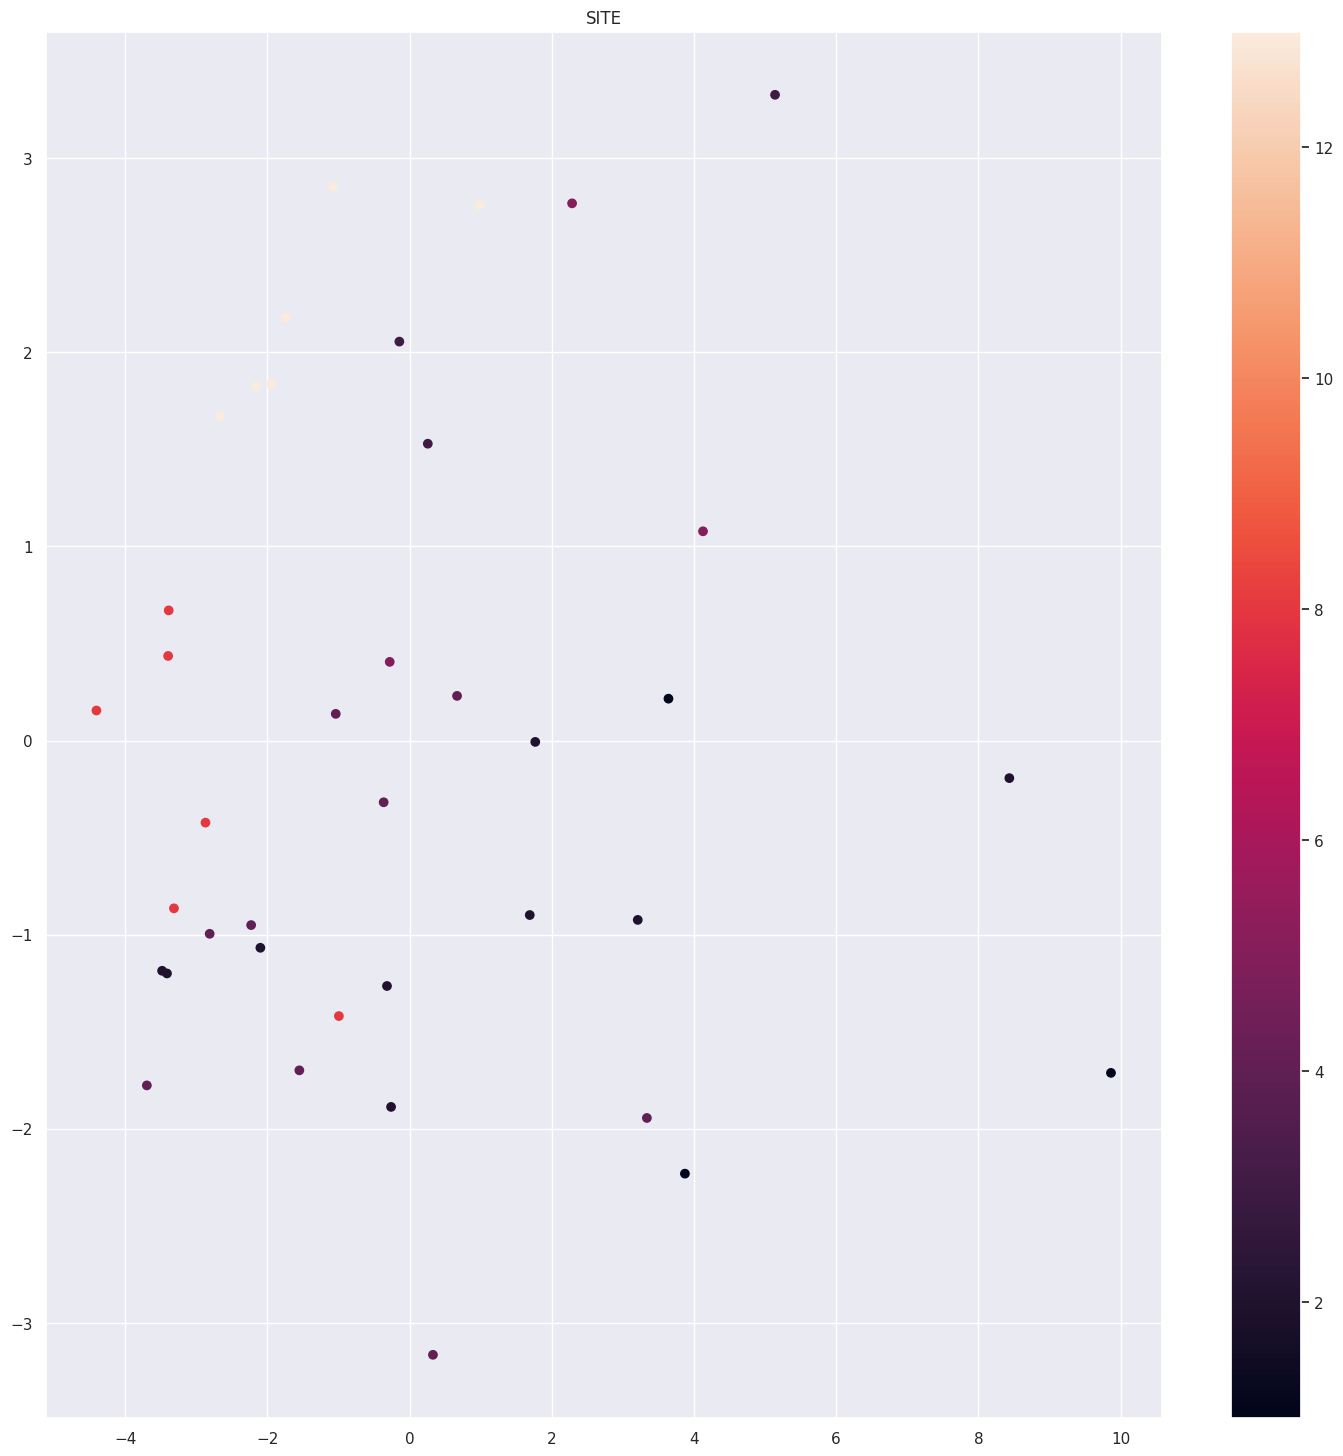

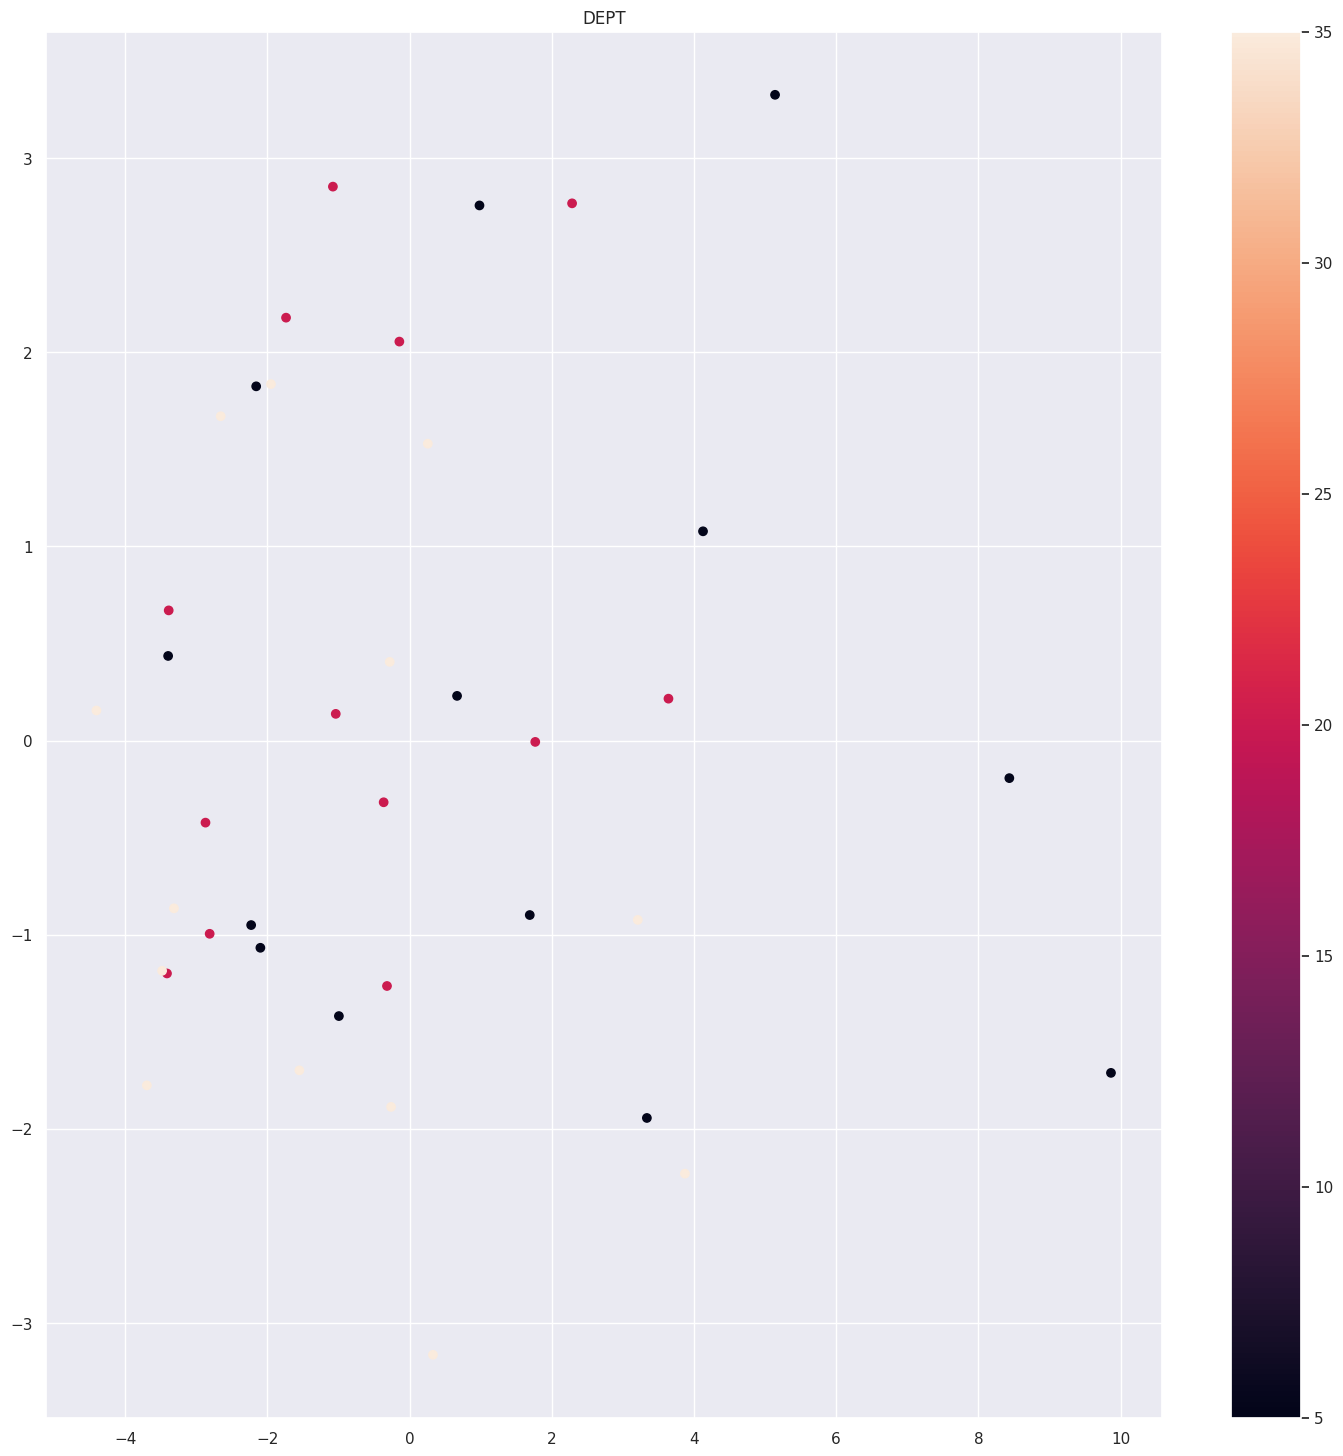

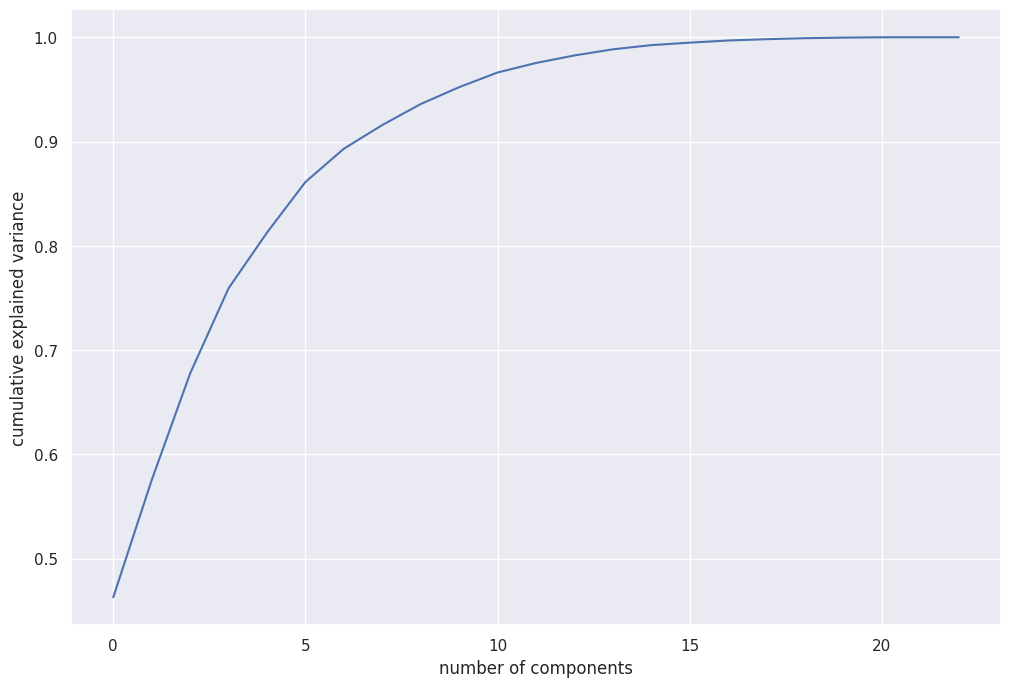

Meaning of the 2 components:
0.16 x Clay + -0.10 x Silt + 0.06 x Sand + 0.09 x pH + 0.22 x Aggregate Stability + -0.19 x Bulk Density + 0.27 x Dissolved Org. Carbon + 0.22 x Carbon-to-Nitrogen + -0.14 x Ergosterol + 0.25 x Microbial Carbon + 0.23 x Microbial Nitrogren + 0.22 x Microbial Phosphorus + 0.02 x Manosamine + 0.17 x Muramic Acid + 0.29 x Glucosamine + 0.26 x Sum Aminosugars + 0.28 x LAP + 0.26 x NAG + 0.24 x GLU + 0.24 x XYL + 0.25 x CEL + 0.25 x PHO 

0.08 x Clay + 0.37 x Silt + -0.40 x Sand + -0.37 x pH + 0.17 x Aggregate Stability + -0.24 x Bulk Density + 0.14 x Dissolved Org. Carbon + 0.15 x Carbon-to-Nitrogen + -0.12 x Ergosterol + 0.05 x Microbial Carbon + -0.01 x Microbial Nitrogren + 0.16 x Microbial Phosphorus + -0.01 x Manosamine + 0.20 x Muramic Acid + 0.09 x Glucosamine + 0.17 x Sum Aminosugars + 0.15 x LAP + -0.18 x NAG + -0.23 x GLU + -0.25 x XYL + -0.24 x CEL + -0.27 x PHO 

-0.12 x Clay + 0.45 x Silt + -0.44 x Sand + -0.08 x pH + -0.17 x Aggregate Stability + 

In [37]:
# Retain90% of variance
pca_soil = PCA(0.9)

# Fit and transform
pca_fit = PCA().fit(Explanatory_Variables)
pca_transform = pca_soil.fit_transform(Explanatory_Variables)
pca_transform_df = pd.DataFrame(pca_transform, index=Explanatory_Variables.index)

# How much info we got
print("Reduce from ",Explanatory_Variables.shape," to ",pca_transform_df.shape, "variables while retaining 90% variance")
print("Explained variance:",np.sum(pca_soil.explained_variance_ratio_))

# Show a scatter plot of the first two components and the respective target variable
for target_var in ["SYSTEM", "SITE", "DEPT"]:
    target_values = Categories[target_var]
    sc = plt.scatter(pca_transform[:,0],pca_transform[:,1], c=target_values)
    plt.colorbar(sc)
    plt.title(target_var)
    plt.show()

# Chart of explained variance
plt.figure(figsize=(12,8))
plt.plot(np.cumsum(pca_fit.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

#Trying to decipher the meaning of the principal components
print("Meaning of the 2 components:")
for component in pca_fit.components_[0:4]:
    print(" + ".join("%.2f x %s" % (value, name)
                     for value, name in zip(component, X_train.columns)),"\n")


# Table of most important components
# get the index of the most important feature on EACH component
n_pcs = pca_soil.components_.shape[0]
most_important = [np.abs(pca_soil.components_[i]).argmax() for i in range(n_pcs)]
most_important_X_train = []
for i in range(len(pca_soil.components_)):
    val = most_important[i]
    most_important_X_train.append(pca_soil.components_[i][val])

# get the names
initial_feature_names = bestand.columns[2:]
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}
most_important_components_df = pd.DataFrame(dic.items())
most_important_components_df["X_train"] = most_important_X_train
print("Most important components:",most_important_components_df)

## F Regression

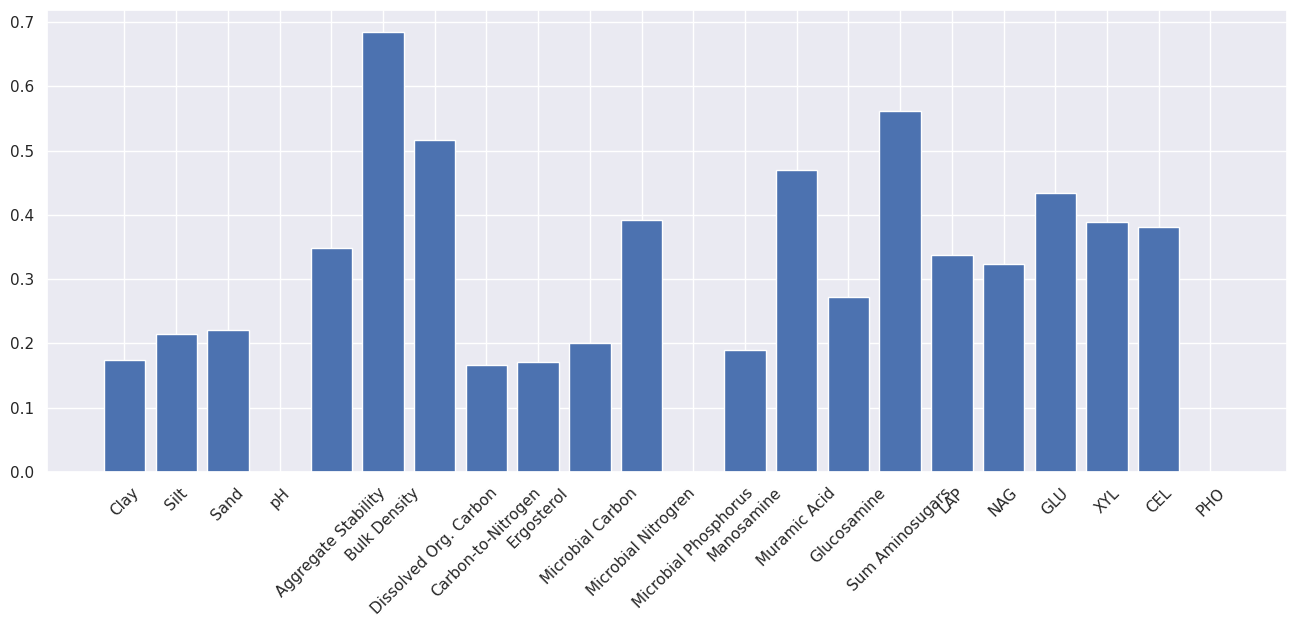

,Aggregate Stability,Bulk Density,Dissolved Org. Carbon,Microbial Nitrogren,Muramic Acid,Sum Aminosugars,LAP,GLU,XYL,CEL
5,1.295883,-0.815832,2.351948,2.892874,2.791553,2.351414,2.653123,3.322344,4.052780,3.685621
7,0.715346,0.342274,0.236836,0.346104,0.577346,0.426826,-0.121377,0.401076,0.597941,0.366506
8,1.427270,-0.998691,0.433498,1.617883,2.679234,2.659968,2.581739,1.462467,1.938991,2.152993
9,-0.989499,1.439428,0.180257,0.206184,-0.475354,-0.585566,-0.549249,-0.747031,-0.496373,-0.607472
11,1.501082,-2.400610,2.333536,0.764988,2.198700,2.298515,0.194754,0.033937,-0.078107,-0.066442


In [38]:
sns.set(rc={'figure.figsize':(16,6)})

# Selekt the k best features
X_fs = SelectKBest(mutual_info_regression, k=10).fit(X,y)
plt.bar([X.columns[i] for i in range(len(X_fs.scores_))], X_fs.scores_)
plt.xticks(rotation = 45)
plt.show()

# Get columns to keep and create new dataframe with those only
cols = X_fs.get_support(indices=True)
X_feature_reduced = X.iloc[:,cols]

# Redo the split with reduced x
X_train_reduced, X_test_reduced, y_train, y_test = train_test_split(X_feature_reduced, y, test_size=0.3, random_state=42)

X_feature_reduced.head()

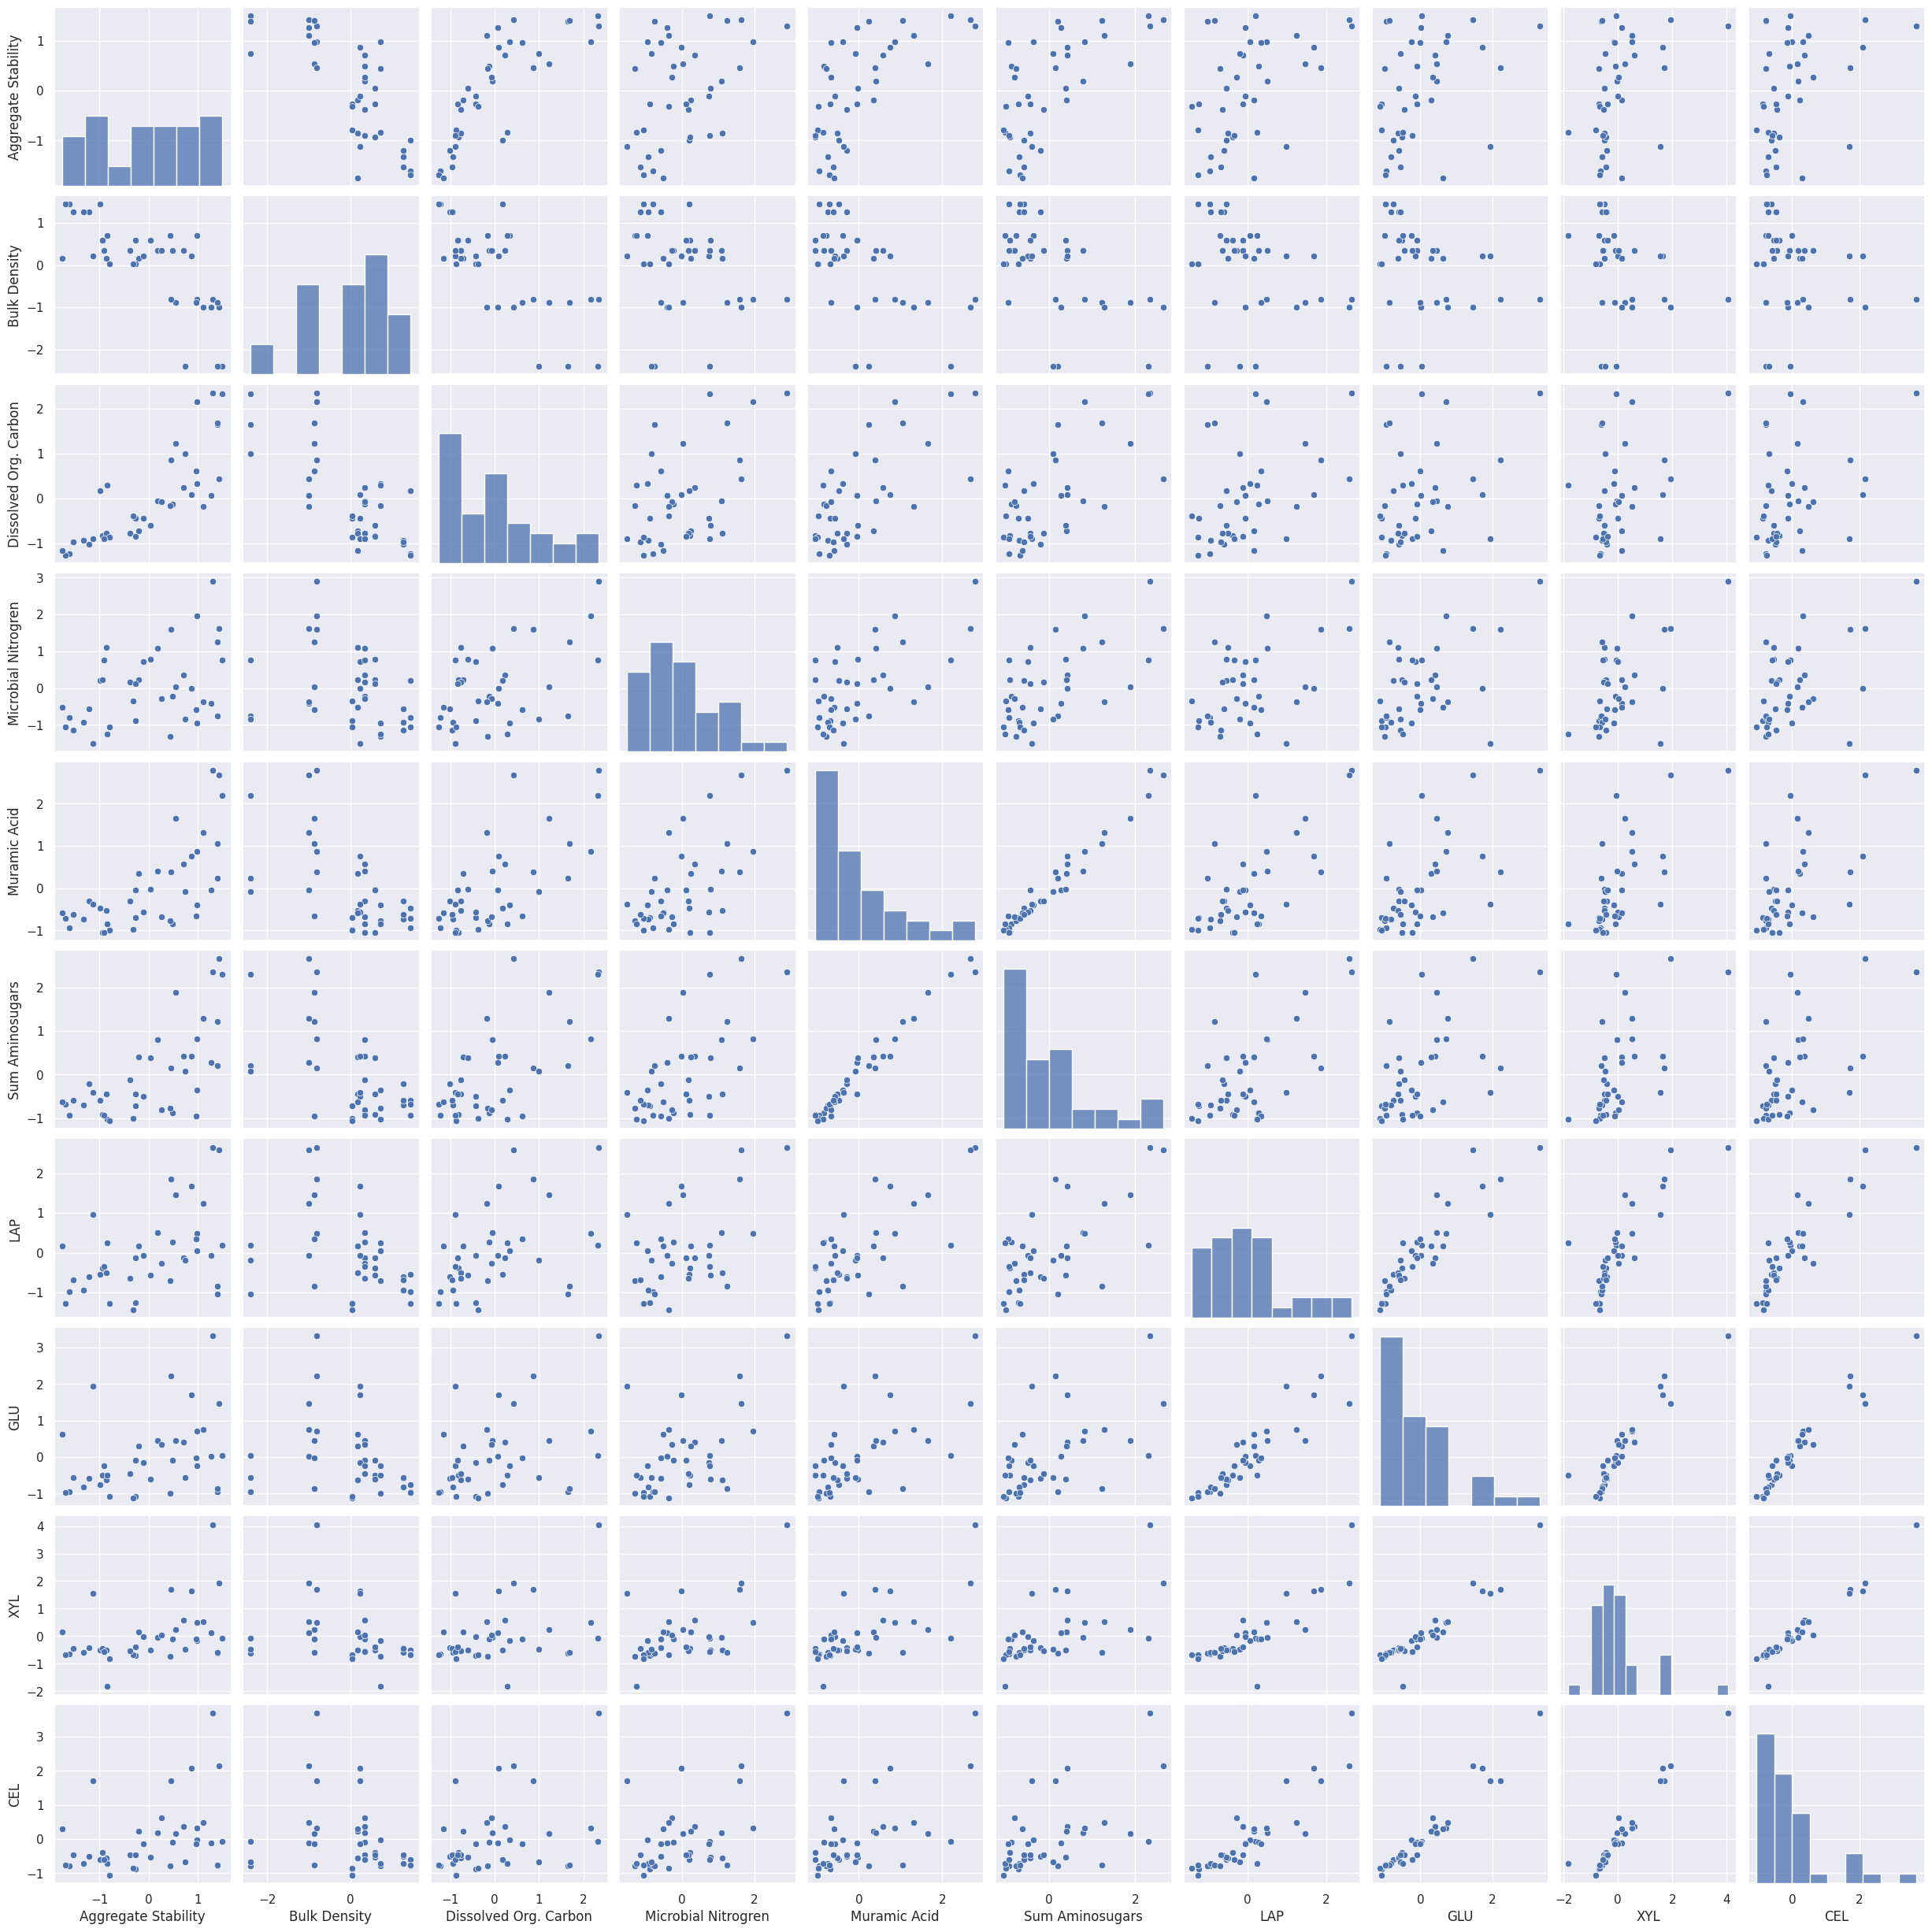

In [31]:
# Pairplot on reduced features:
sns.pairplot(X_feature_reduced)

# ANCOVA

In [39]:
ancova_result = ancova(data=bestand, dv=target, covar='SITE', between='SYSTEM')
display("ANCOVA:",ancova_result)
# ‘Source’: Names of the factor considered
# ‘SS’: Sums of squares
# ‘DF’: Degrees of freedom
# ‘F’: F-values
# ‘p-unc’: Uncorrected p-values
# ‘np2’: Partial eta-squared

tukey = pairwise_tukeyhsd(endog=bestand[target], groups=bestand['SYSTEM'], alpha=0.05)
print("Tukey:\n",tukey)

'ANCOVA:'

,Source,SS,DF,F,p-unc,np2
0,SYSTEM,10.143932,2,7.458129,0.002004,0.298826
1,SITE,0.484185,1,0.711975,0.404519,0.019937
2,Residual,23.802056,35,NaN,NaN,NaN


Tukey:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1   0.7649 0.0546 -0.0127  1.5424  False
     0      2  -0.8009 0.0423 -1.5785 -0.0234   True
     1      2  -1.5658 0.0001 -2.3854 -0.7462   True
----------------------------------------------------


# Machine Learning

## Random Forest All Features

In [40]:
model = RandomForestRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

display("Feature Importance: ",pd.DataFrame({'Variable':X.columns,'Importance':model.feature_importances_}).sort_values('Importance', ascending=False))

mse = mean_squared_error(y_test, model.predict(X_test))
mae = mean_absolute_error(y_test, model.predict(X_test))
rmspe = (np.sqrt(np.mean(np.square((y_test - model.predict(X_test)) / y_test)))) * 100
mape = mean_absolute_percentage_error(y_test, model.predict(X_test))

print("\nmse = ",mse,"\nmae = ",mae,"\nrmse = ", sqrt(mse),"\nrmspe = ",rmspe, "\nmape = ",round(mape * 100, 2))

'Feature Importance: '

,Variable,Importance
14,Glucosamine,0.147877
5,Bulk Density,0.143901
4,Aggregate Stability,0.108837
10,Microbial Nitrogren,0.106768
6,Dissolved Org. Carbon,0.082303
13,Muramic Acid,0.078211
15,Sum Aminosugars,0.072314
20,CEL,0.049620
7,Carbon-to-Nitrogen,0.048481
18,GLU,0.033046



mse =  0.481762084828458 
mae =  0.573014450678183 
rmse =  0.6940908332692904 
rmspe =  87.66643054526378 
mape =  69.81


## Random Forest Selected Features

In [41]:
model = RandomForestRegressor()
model.fit(X_train_reduced, y_train)
y_pred = model.predict(X_test_reduced)

display("Feature Importance: ",pd.DataFrame({'Variable':X_feature_reduced.columns,'Importance':model.feature_importances_}).sort_values('Importance', ascending=False))

mse = mean_squared_error(y_test, model.predict(X_test_reduced))
mae = mean_absolute_error(y_test, model.predict(X_test_reduced))
rmspe = (np.sqrt(np.mean(np.square((y_test - model.predict(X_test_reduced)) / y_test)))) * 100
mape = mean_absolute_percentage_error(y_test, model.predict(X_test_reduced))

print("\nmse = ",mse,"\nmae = ",mae,"\nrmse = ", sqrt(mse),"\nrmspe = ",rmspe, "\nmape = ",round(mape * 100, 2))

'Feature Importance: '

,Variable,Importance
1,Bulk Density,0.235345
0,Aggregate Stability,0.211010
4,Muramic Acid,0.121163
3,Microbial Nitrogren,0.113015
5,Sum Aminosugars,0.100316
2,Dissolved Org. Carbon,0.095338
6,LAP,0.044247
9,CEL,0.027754
8,XYL,0.027453
7,GLU,0.024359



mse =  0.4556266513624084 
mae =  0.5024769588849487 
rmse =  0.6750012232303052 
rmspe =  78.82831232799664 
mape =  54.46


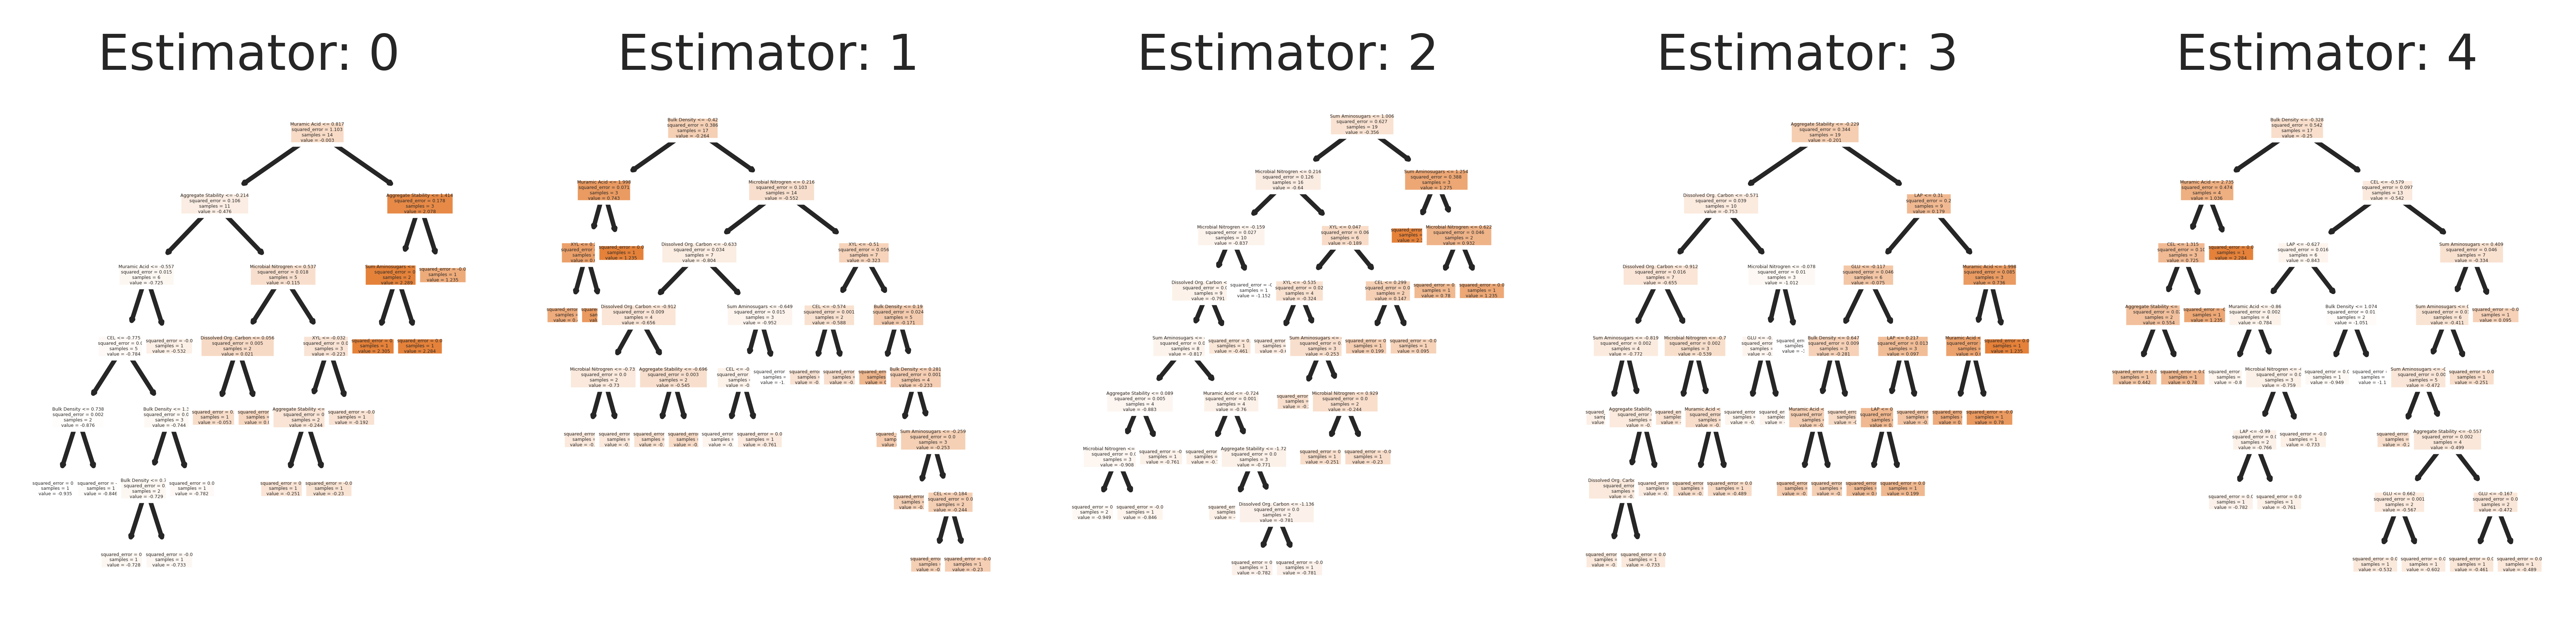

In [30]:
from sklearn.tree import plot_tree

fig, axes = plt.subplots(nrows = 1,ncols = 5,figsize = (10,2), dpi=900)
for index in range(0, 5):
    tree.plot_tree(model.estimators_[index],
                   feature_names = X_feature_reduced.columns, 
                   class_names=target,
                   filled = True,
                   ax = axes[index]);

    axes[index].set_title('Estimator: ' + str(index), fontsize = 11)

In [42]:
import lime
import lime.lime_tabular
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(8,5)})

explainer = lime.lime_tabular.LimeTabularExplainer(X_train_reduced.values, feature_names=X_train_reduced.columns, class_names=[target], verbose=True, mode='regression')

def plot_explain(i):
    exp = explainer.explain_instance(X_test_reduced.iloc[int(i)], model.predict, num_features=5)
    fig = exp.as_pyplot_figure()
    fig.show()

%matplotlib inline

import numpy as np

interact(plot_explain, i = widgets.FloatSlider(value=1, min=1, max=10, step=1))


interactive(children=(FloatSlider(value=1.0, description='i', max=10.0, min=1.0, step=1.0), Output()), _dom_cl…

<function __main__.plot_explain(i)>